In [1]:
import os
import ipyplot
import numpy as np

import torch
import torch.utils.checkpoint

from accelerate.logging import get_logger
from diffusers import DDIMScheduler
from diffusers.utils import check_min_version

from utils.pipeline_controlnet import LightControlNetPipeline
from utils.light_controlnet import ControlNetModel
from utils.unet_2d_condition import UNet2DConditionNewModel

from PIL import Image

import sys
os.chdir("/home/yxiu/Code/oft-butterfly/oft-controlnet")
sys.path.append("./peft/src")
from peft import PeftModel

from utils.dataset import CelebHQDataset as ControlNetDataset

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.10.0.dev0")

logger = get_logger(__name__)
device = torch.device("cuda:0")

MODEL_NAME = "stabilityai/stable-diffusion-2-1"  # "stabilityai/stable-diffusion-2-1-base"
# MODEL_NAME="runwayml/stable-diffusion-v1-5"
base_path = "/home/yxiu/Code/oft-butterfly/oft-controlnet"
val_dataset = ControlNetDataset(split="val", resolution=512, full=True)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/yxiu/miniconda3/envs/OPT/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/yxiu/miniconda3/envs/OPT/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/yxiu/miniconda3/envs/OPT/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


Detected CUDA files, patching ldflags
Emitting ninja build file /tmp/build.ninja...
Building extension module fbd_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module fbd_cuda...
No modifications detected for re-loaded extension module fbd_cuda, skipping build step...
Loading extension module fbd_cuda...


ninja: no work to do.


In [2]:
%reload_ext autoreload
%autoreload 2

adapter_name = "boft_3205_stable"
ckpt_name = "checkpoint-33000"
# ckpt_name = "."

controlnet_path = os.path.join(base_path, 
                               f"data/output/celebhq/{adapter_name}/{ckpt_name}/controlnet/model.safetensors")

unet_path = os.path.join(base_path, 
                               f"data/output/celebhq/{adapter_name}/{ckpt_name}/unet/{adapter_name}")

# print(controlnet_path)

controlnet = ControlNetModel()
controlnet.load_state_dict(torch.load(controlnet_path))
unet = UNet2DConditionNewModel.from_pretrained(MODEL_NAME,subfolder="unet")
unet = PeftModel.from_pretrained(unet, unet_path, adapter_name=adapter_name)

In [3]:
pipe = LightControlNetPipeline.from_pretrained(
        MODEL_NAME,
        controlnet = controlnet,
        unet = unet.model,
        torch_dtype=torch.float32, 
        requires_safety_checker=False
).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/yxiu/miniconda3/envs/OPT/lib/python3.9/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



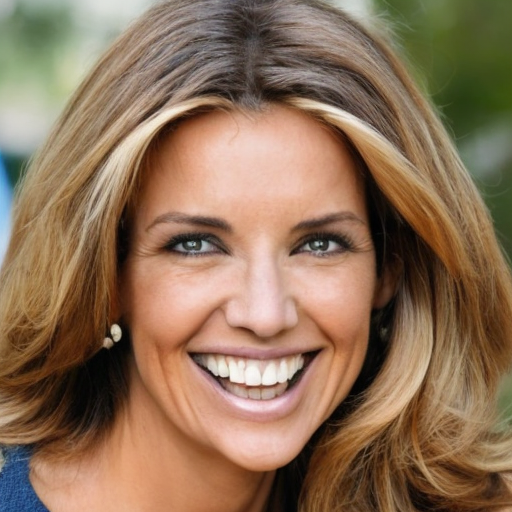
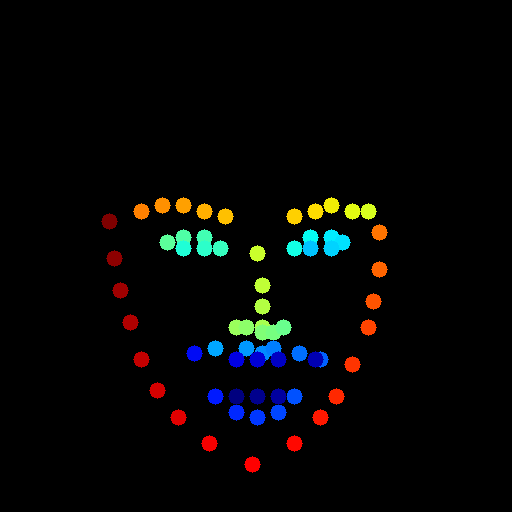
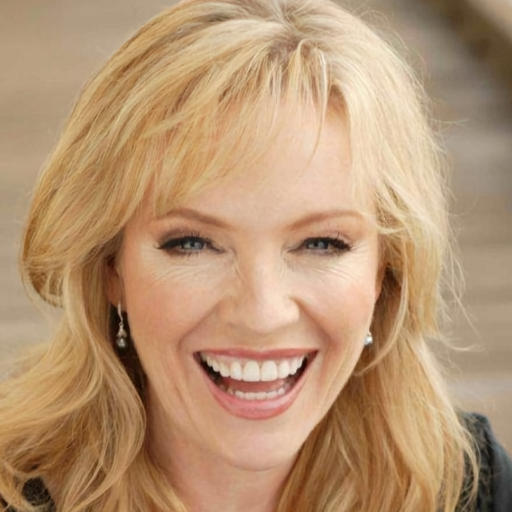


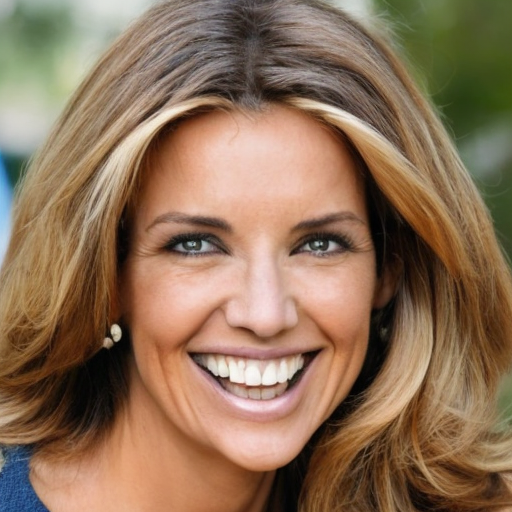
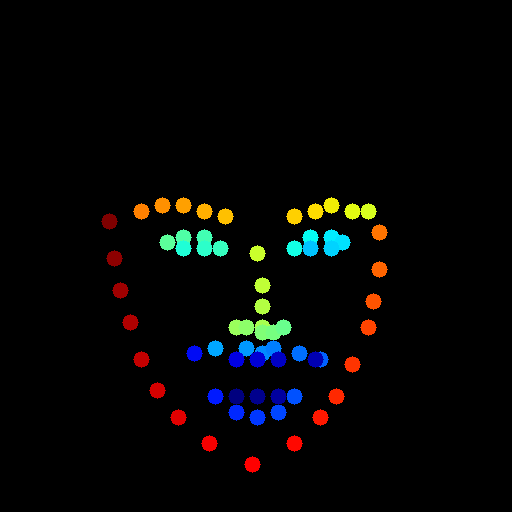
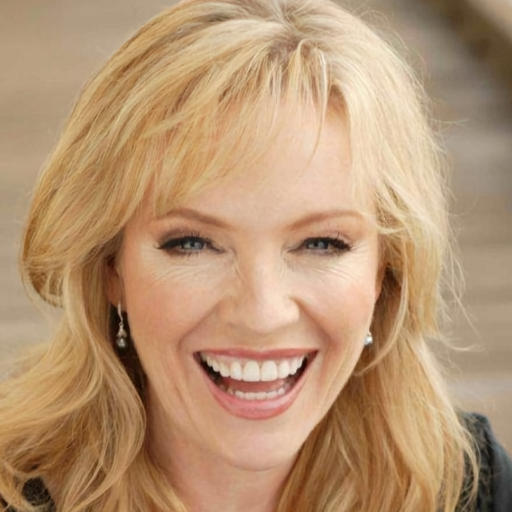

a smiling woman


In [4]:
%reload_ext autoreload
%autoreload 2

data = val_dataset[99]
negative_prompt = "low quality, blurry, unfinished"

generator = torch.Generator(device=device).manual_seed(1993)

pred_img = pipe(data["caption"], 
             [data["conditioning_pixel_value"]],
             num_inference_steps=50, 
             generator=generator,
             guidance_scale=7, 
             negative_prompt=negative_prompt
            ).images[0]

control_img = Image.fromarray((data["conditioning_pixel_value"]*255).numpy().transpose(1,2,0).astype(np.uint8))
gt_img = Image.fromarray(((data["pixel_value"]+1.0)*0.5*255).numpy().transpose(1,2,0).astype(np.uint8))
images_array = [pred_img, control_img, gt_img]
ipyplot.plot_images(images_array, max_images=20, img_width=300, labels=["pred", "condition", "gt"])
print(data["caption"])

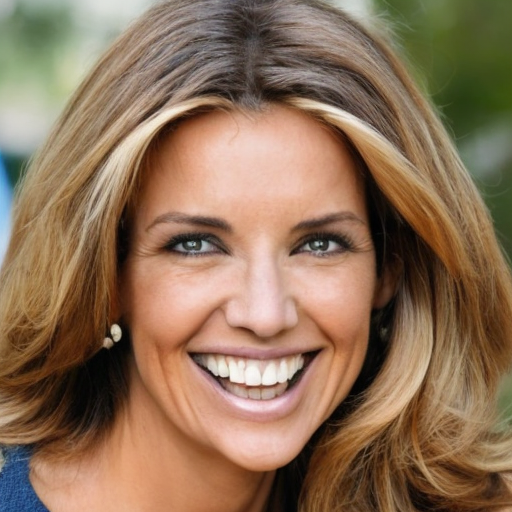

In [5]:
pred_img
# unet = UNet2DConditionModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision)
# config = OFTConfig(oft_r=32, target_modules=UNET_TARGET_MODULES, oft_dropout=0.1, bias="none", oft_bias_fit=False)
# config = BOFTConfig(boft_block_size=0, boft_block_num=32, boft_n_butterfly_factor=5, target_modules=UNET_TARGET_MODULES, boft_dropout=0.1, bias="none")
# config = LoraConfig(r=32, lora_alpha=27, target_modules=UNET_TARGET_MODULES, lora_dropout=0.1, bias="none")